In [2]:
import os
os.environ['OPENCV_IO_ENABLE_JASPER']='True' # reading jp2000 images
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio as rio
from rasterio.windows import Window
import random
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision.models as models

In [2]:
city = 'hamilton'
crop_size = 512
EXPERIMENT_NAME = 'test2'
TOTAL_EPOCHS = 500
LR = 1e-4
WD = 5e-4
test_freq = 5

PATH_DIRECTORY = '/mnt/mount-point-directory/building_footprint/'
PATH_DATA = os.path.join(PATH_DIRECTORY, 'data')

PATH_DATA_BUILDING_POLYGON = os.path.join(PATH_DIRECTORY, 'data', 'building_polygon', 'tiles_jp2')
PATH_DATA_ROAD_FILL = os.path.join(PATH_DIRECTORY, 'data', 'road_fill', 'tiles_jp2')
PATH_DATA_CITY = os.path.join('/mnt/mount-point-directory/datasets/', city, 'VRT')

PATH_DATA_DRIVEWAY_POLYGON = os.path.join(PATH_DIRECTORY, 'data', 'driveways_polygon', 'tiles_jp2')

In [3]:
list_building_polygon = os.listdir('/mnt/mount-point-directory/building_footprint/data/building_polygon/tiles_jp2/')

In [4]:
list_images = os.listdir(os.path.join(PATH_DATA_CITY))
list_road = os.listdir(os.path.join(PATH_DATA_ROAD_FILL))
list_building = os.listdir(os.path.join(PATH_DATA_BUILDING_POLYGON))

list_driveway = os.listdir(os.path.join(PATH_DATA_DRIVEWAY_POLYGON))

In [5]:
PATH_DIRECTORY = '/mnt/mount-point-directory/building_footprint/'
PATH_DATA = os.path.join(PATH_DIRECTORY, 'data')

PATH_DATA_BUILDING_POLYGON = os.path.join(PATH_DIRECTORY, 'data', 'building_polygon', 'tiles_jp2')
PATH_DATA_ROAD_FILL = os.path.join(PATH_DIRECTORY, 'data', 'road_fill', 'tiles_jp2')
PATH_DATA_CITY = os.path.join('/mnt/mount-point-directory/datasets/', city, 'VRT')

PATH_DATA_DRIVEWAY_POLYGON = os.path.join(PATH_DIRECTORY, 'data', 'driveways_polygon', 'tiles_jp2')

In [6]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import transforms
import csv
import PIL
from tqdm import tqdm

In [7]:
class ValTestDrivewayDataset(Dataset):
    def __init__(self, path_directory, mode):
        self.path_directory = path_directory
        
        self.namefile = open(os.path.join(self.path_directory, (mode + '.txt')), 'r')
        self.reader = csv.reader(self.namefile)
        self.image_names = [row[0] for row in self.reader]
        
        self.crop_size = 768
        self.reshape = True
        self.reshape_size = 512
        
        self.to_pil = transforms.ToPILImage()
#         self.color_jit = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.05)
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return(len(self.image_names))
        
    def __getitem__(self, index):
        # randomly choose an image
        file_name = random.choice(self.image_names)
        
        # prepapre reading paths
        path_img = os.path.join('/mnt/mount-point-directory/datasets/', city, 'VRT')
        path_building = os.path.join(self.path_directory, 'data', 'building_polygon', 'tiles_jp2')
        path_road = os.path.join(self.path_directory, 'data', 'road_fill', 'tiles_jp2')
        path_driveway = os.path.join(self.path_directory, 'data', 'driveways_polygon', 'tiles_jp2')
        
        # read src datasets
        src_img = rio.open(os.path.join(path_img, file_name), mode = 'r')
        src_building = rio.open(os.path.join(path_building, file_name), mode ='r')
        src_road = rio.open(os.path.join(path_road, file_name), mode = 'r')
        src_driveway = rio.open(os.path.join(path_driveway, file_name), mode = 'r')
        
        meta = src_img.meta
        x_lim = meta['width'] - self.crop_size 
        y_lim = meta['height'] - self.crop_size
        
        # find a random path until there is some data in it
#         while True: 
#             col_off = np.random.randint(0, x_lim)
#             row_off = np.random.randint(0, y_lim)

#             window = Window(col_off=col_off,
#                 row_off=row_off,
#                 width=self.crop_size,
#                 height=self.crop_size)

#             _mask = src_driveway.read(window = window)
#             print(window)
#             if _mask.any():
#                 break

        col_off = np.random.randint(0, x_lim)
        row_off = np.random.randint(0, y_lim)

        window = Window(col_off=col_off,
            row_off=row_off,
            width=self.crop_size,
            height=self.crop_size)

        _mask = src_driveway.read(window = window)
        
                
        # read images, if you get nullpointer error in img read, there is a channel issue. Reformat the images.
        _img = src_img.read((1,2,3), window = window)
        _mask_building = src_building.read(1, window = window)
        _mask_road = src_road.read(1, window = window)
        _mask_driveway = src_driveway.read(1, window = window)
        
        _input_tensor, _mask = self.transform(_img, _mask_building, _mask_road, _mask_driveway)
        
        return _input_tensor, _mask
        
    def transform(self, img, mask_building, mask_road, mask_driveway):
        """
        Input Tensor, Ouput Tensor
        
        """
        
        # To Tensor
        img = torch.tensor(img)
        mask_building = torch.tensor(mask_building)
        mask_road = torch.tensor(mask_road)
        mask_driveway = torch.tensor(mask_driveway)
        
        # To PIL image
        image = self.to_pil(img)
        mask_building = self.to_pil(mask_building)
        mask_road = self.to_pil(mask_road)
        mask_driveway = self.to_pil(mask_driveway)
        
        # Resize
        image = TF.resize(image, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_building = TF.resize(mask_building, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_road = TF.resize(mask_road, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        mask_driveway = TF.resize(mask_driveway, size = self.reshape_size, interpolation=PIL.Image.NEAREST)
        
        # Change to tensors
        image = self.to_tensor(image)
        mask_building = self.to_tensor(mask_building)
        mask_road = self.to_tensor(mask_road)
        mask_driveway = self.to_tensor(mask_driveway)
        
        # Merge input tensors to 5 channel, 3 image 1 building 1 road
        _input_stacked = torch.cat((image, mask_building, mask_road))
        
        return _input_stacked, mask_driveway

In [8]:
import torchvision
import torchvision.models as models
from collections import OrderedDict

In [17]:
def get_model(path_to_model, model_train_on = 'cpu'):
    checkpoint = torch.load(path_to_model, map_location=torch.device('cpu'))

    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=1, aux_loss=None)
    model.backbone.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # original saved file with DataParallel
    # create new OrderedDict that does not contain `module.`
    
    if model_train_on != 'cpu':
        new_state_dict = OrderedDict()
        for k, v in checkpoint['state_dict'].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

    # load params
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(checkpoint['state_dict'])

    model.eval()

    return model

In [18]:
path_to_model = './save/test2/model_best.pth.tar'

In [19]:
model = get_model(path_to_model, 'cpu')

In [20]:
test_ds = ValTestDrivewayDataset(PATH_DIRECTORY, mode = 'test')
test_loader = DataLoader(test_ds, batch_size = 1, shuffle = False, num_workers = 8)

In [21]:
def compute_miou(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    
    return np.mean(IoU)

In [44]:
i, sample = next(enumerate(test_loader))

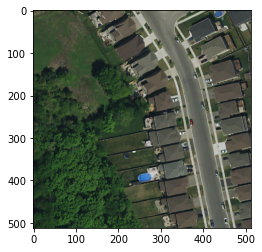

In [45]:
plt.imshow((sample[0][0][:3]).numpy().transpose(1,2,0))

In [46]:
with torch.no_grad():
    _output = model(sample[0])
    _gt = sample[1]

In [47]:
arr_building = sample[0][0][3:4].numpy()
arr_building[arr_building == 0] = 'nan'

In [48]:
arr_road = sample[0][0][4:5].numpy()
arr_road[arr_road == 0] = 'nan'

In [49]:
arr_driveway = _gt[0][0].numpy()
arr_driveway[arr_driveway == 0] = 'nan'

In [50]:
pred_driveway = (torch.sigmoid(_output['out'][0,0,:,:]))

In [51]:
arr_pred_driveway = (pred_driveway>0.5).numpy().astype(float)
arr_pred_driveway[arr_pred_driveway == 0] = 'nan'

Text(0.5, 1.0, 'Prediction, RED = Driveway GT, BLUE = House GT and Road GT')

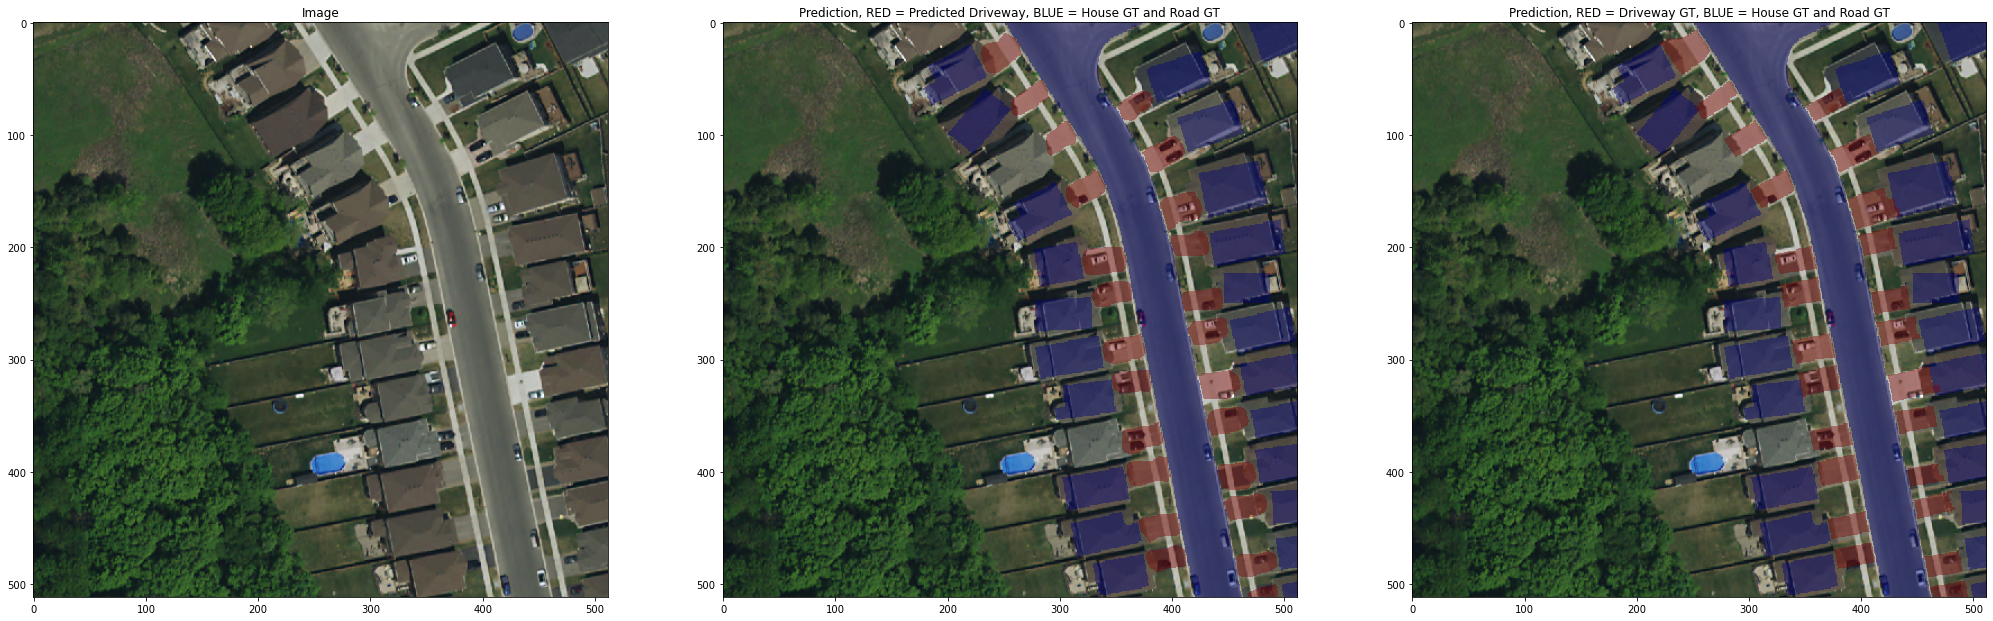

In [52]:
plt.figure(figsize = (35,40))
plt.subplot(1,3,1)
plt.imshow((sample[0][0][:3]).numpy().transpose(1,2,0))
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(sample[0][0][:3].numpy().transpose(1,2,0))
plt.imshow(arr_building[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_road[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_pred_driveway, alpha = 0.4, cmap = 'jet_r')
plt.title('Prediction, RED = Predicted Driveway, BLUE = House GT and Road GT')

plt.subplot(1,3,3)
plt.imshow(sample[0][0][:3].numpy().transpose(1,2,0))
plt.imshow(arr_building[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_road[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_driveway, alpha = 0.4, cmap = 'jet_r')
plt.title('Prediction, RED = Driveway GT, BLUE = House GT and Road GT')


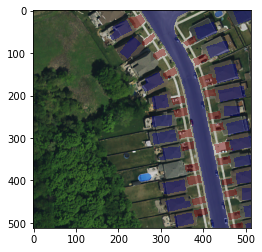

In [53]:
plt.imshow(sample[0][0][:3].numpy().transpose(1,2,0))
plt.imshow(arr_building[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_road[0], alpha = 0.4, cmap = 'jet')
plt.imshow(arr_driveway, alpha = 0.4, cmap = 'jet_r')

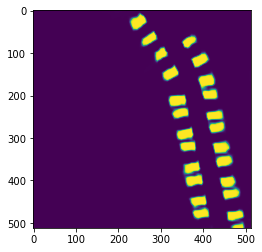

In [55]:
plt.imshow(torch.sigmoid(_output['out'][0,0,:,:]))